In [23]:
from result_saver import SaverProvider, metadata_helper, metadata_loader
import pandas as pd
import numpy as np
import networkx as nx
from itertools import combinations

provider = SaverProvider()
backend = provider.get_backend('ibm_brisbane')

# Testing functions

In [27]:
from soft_info import find_longest_path_general, find_longest_path_in_hex

path, length, start_qubit = find_longest_path_general(backend, plot=True)
print(f"Longest path: {path}, length: {length}, start qubit: {start_qubit}")

Finding the longest path:  31%|███       | 39/127 [01:23<02:57,  2.02s/it]

In [ ]:
path, length, start_qubit = find_longest_path_in_hex(backend, plot=True)
print(f"Longest path: {path}, length: {length}, start qubit: {start_qubit}")

In [ ]:
from soft_info import create_coupling_graph_with_positions

coupling_graph = create_coupling_graph_with_positions(backend)
nx.draw(coupling_graph, with_labels=True)

# Find longest path


In [ ]:
from qiskit import QuantumCircuit, transpile

provider = SaverProvider()
backend = provider.get_backend('ibm_brisbane')
coupling_map = backend.configuration().coupling_map


In [ ]:
def find_longest_path_dfs(G, start, visited, path, longest_path):
    visited.add(start)
    path.append(start)
    
    if len(path) > len(longest_path[0]):
        longest_path[0] = path.copy()

    for neighbor in G.neighbors(start):
        if neighbor not in visited:
            find_longest_path_dfs(G, neighbor, visited, path, longest_path)
    
    visited.remove(start)
    path.pop()

def find_longest_path_in_hex(coupling_map):
    G = nx.Graph()
    for edge in coupling_map:
        G.add_edge(edge[0], edge[1])

    corner_nodes = [node for node in G.nodes() if G.degree(node) == 1]
    
    if len(corner_nodes) != 2:
        return f"Not a valid heavy hex map, found {len(corner_nodes)} corner nodes instead of 2."

    visited = set()
    longest_path = [[]]
    find_longest_path_dfs(G, corner_nodes[0], visited, [], longest_path)
    
    return longest_path[0]


# Find the longest path
longest_path = find_longest_path_in_hex(coupling_map)
print("The longest path passes through qubits:", longest_path)
print("The length of the longest path is:", len(longest_path))


The longest path passes through qubits: [13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0, 14, 18, 19, 20, 33, 39, 38, 37, 52, 56, 57, 58, 71, 77, 76, 75, 90, 94, 95, 96, 109, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 112, 108, 107, 106, 105, 104, 103, 102, 101, 100, 99, 98, 91, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 74, 70, 69, 68, 67, 66, 65, 64, 63, 62, 61, 60, 53, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 36, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 15]
The length of the longest path is: 109


In [15]:
from tqdm import tqdm
import networkx as nx

coupling_map = provider.get_backend('ibm_brisbane').configuration().coupling_map

def find_longest_path_dfs(G, start, visited, path, longest_path_info):
    visited.add(start)
    path.append(start)

    if len(path) > longest_path_info[0]:
        longest_path_info[0] = len(path)
        longest_path_info[1] = path.copy()
        longest_path_info[2] = start

    for neighbor in G.neighbors(start):
        if neighbor not in visited:
            find_longest_path_dfs(G, neighbor, visited, path, longest_path_info)

    visited.remove(start)
    path.pop()

def find_longest_path_general(coupling_map):
    G = nx.Graph()
    for edge in coupling_map:
        G.add_edge(edge[0], edge[1])

    longest_path_info = [0, [], None]  # Length of longest path, longest path, starting qubit

    for start_qubit in tqdm(G.nodes(), desc="Finding the longest path"):
        visited = set()
        find_longest_path_dfs(G, start_qubit, visited, [], longest_path_info)

    length, path, start_qubit = longest_path_info
    return path, length, start_qubit

path, length, start_qubit = find_longest_path_general(coupling_map)
print(f"The longest path has length {length}, starts from qubit {start_qubit}, and is {path}")

Finding the longest path: 100%|██████████| 127/127 [04:27<00:00,  2.10s/it]

The longest path has length 109, starts from qubit 123, and is [3, 2, 1, 0, 14, 18, 19, 20, 33, 39, 38, 37, 52, 56, 57, 58, 59, 60, 53, 41, 42, 43, 44, 45, 46, 47, 35, 28, 27, 26, 25, 24, 23, 22, 15, 4, 5, 6, 7, 8, 9, 10, 11, 12, 17, 30, 31, 32, 36, 51, 50, 49, 55, 68, 69, 70, 74, 89, 88, 87, 86, 85, 73, 66, 65, 64, 63, 62, 72, 81, 82, 83, 92, 102, 101, 100, 99, 98, 91, 79, 78, 77, 76, 75, 90, 94, 95, 96, 109, 114, 115, 116, 117, 118, 119, 120, 121, 122, 111, 104, 105, 106, 107, 108, 112, 126, 125, 124, 123]


# Plot v2

In [18]:
%reload_ext autoreload
%autoreload 2

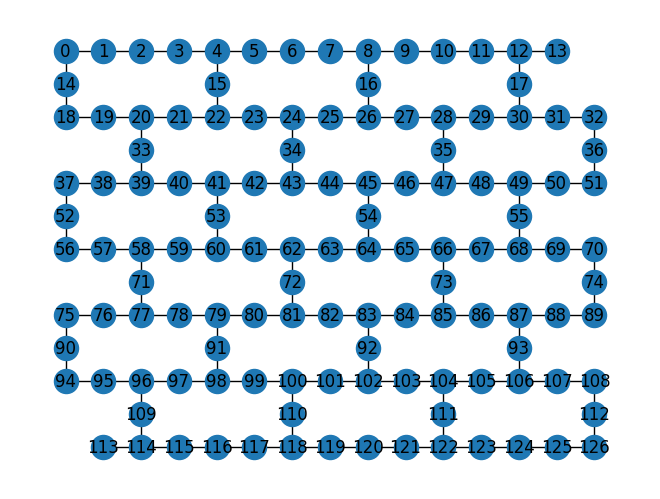

In [19]:
import networkx as nx
from networkx import set_node_attributes
from Scratch import get_qubit_coordinates
import json


def add_qubit_positions(G, n_qubits : int):
    """Add position attributes to the graph nodes."""

    qubit_coordinates = get_qubit_coordinates(n_qubits)
    pos_dict = {}
    for qubit, coordinates in enumerate(qubit_coordinates):
        pos_dict[qubit] = coordinates
    set_node_attributes(G, pos_dict, 'pos')

def create_coupling_graph_with_positions(backend):
    """Create a graph from the coupling map and add qubit positions."""
    coupling_map = backend.configuration().coupling_map
    n_qubits = backend.configuration().n_qubits
    G = nx.Graph()
    for edge in coupling_map:
        G.add_edge(edge[0], edge[1])
    add_qubit_positions(G, n_qubits)
    return G

G = create_coupling_graph_with_positions(backend)

nx.draw(G, pos=nx.get_node_attributes(G, 'pos'), with_labels=True)


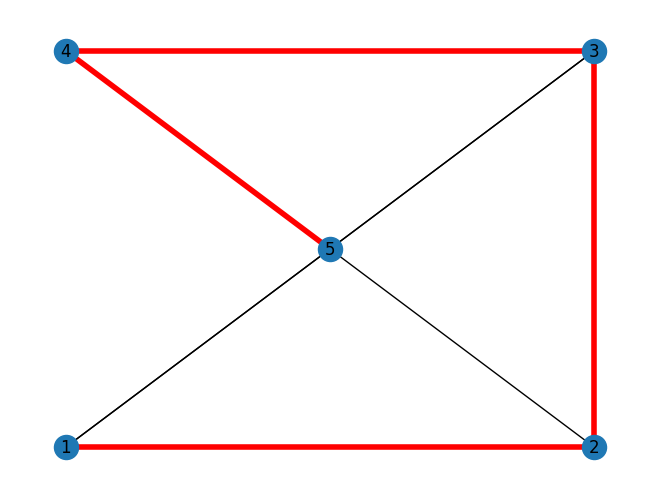

In [21]:
import matplotlib.pyplot as plt
import networkx as nx

def highlight_path(G, path):
    """
    Highlights a path in a NetworkX graph.

    Parameters:
    - G (Graph): The NetworkX graph
    - path (list): A list of nodes that make up the path to highlight

    Returns:
    None
    """

    pos = nx.get_node_attributes(G, 'pos')

    # Draw the base graph
    nx.draw(G, pos, with_labels=True)

    # Generate edge tuples for the path
    path_edges = [(path[i], path[i+1]) for i in range(len(path) - 1)]

    # Highlight the path
    nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color='red', width=4)

    plt.show()

# Create a sample graph
G = nx.Graph()
G.add_edges_from([(1, 2), (2, 3), (3, 4), (4, 5), (5, 1), (1, 3), (2, 4), (3, 5)])
nx.set_node_attributes(G, {1: (0, 0), 2: (1, 0), 3: (1, 1), 4: (0, 1), 5: (0.5, 0.5)}, 'pos')

# Specify a path to highlight
highlight_path(G, [1, 2, 3, 4, 5])


# Plot the longest snake

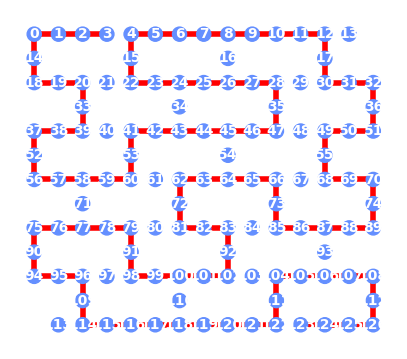

In [16]:
from qiskit.visualization import plot_gate_map

longest_snake = path

backend = provider.get_backend('ibm_brisbane')

longest_path = [[longest_snake[i], longest_snake[i+1]] for i in range(len(longest_snake)-1)]

line_colors = []
for edge in coupling_map:
    if edge in longest_path or edge[::-1] in longest_path:
        line_colors.append('red')
    else:
        line_colors.append('white')  # or any other default color


# Plot the coupling map
plot_gate_map(backend, plot_directed=False, line_color=line_colors, figsize=(5, 5))

Custom Warning: divide by zero encountered in det

Custom Warning: invalid value encountered in det



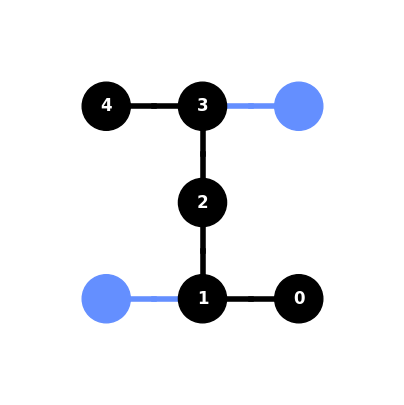

In [70]:
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_circuit_layout

backend = provider.get_backend('ibmq_jakarta')

qc = QuantumCircuit(5, 5)
qc.cx(0, 1)
qc.cx(1, 2)
qc.cx(2, 3)
qc.cx(3, 4)
qc.measure(range(5), range(5))

# Transpile the circuit
qc_transpiled = transpile(qc, backend=backend, optimization_level=3)
#qc_transpiled.draw(fold=-1)

# Plot the circuit with the layout
plot_circuit_layout(qc_transpiled, backend)


# 